# DFUC24 Baseline: GroundingDINO + SAM for ulcer object detection and semantic segmentation on DFUC22 dataset

The author of this notebook is Benjamin Bracke ([Github](https://github.com/B-Bracke)).

## Imports

In [2]:
import os
import glob
import copy
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import autocast

from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, BinaryRecall, BinaryPrecision, BinaryConfusionMatrix
from torchmetrics.detection.iou import IntersectionOverUnion
from torchmetrics.detection.mean_ap import MeanAveragePrecision

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "1"

## Defining important path variables

In [ ]:
ROOT_DIR = os.path.abspath(os.getcwd()) # current path of the notebook
DATA_DIR = "/raid/DFUC24/datasets/dfuc2022/sep/" # path to the dataset root directory
IMAGE_FILES = os.path.join(DATA_DIR, "images/") # path to the images
ANNOTATION_FILES = os.path.join(DATA_DIR, "labels/") # path to the ground truth annotations

print("Directories:")
print("Root directory:", ROOT_DIR)
print("Image files in directory:", IMAGE_FILES)
print("Ground Truth annotations files in directory:", ANNOTATION_FILES)

## Data set

### Define the dataset class, pre-processing and augmentation pipelines and helper functions

In [ ]:
class DFUC22_ODDataset(Dataset):
    def __init__(self, image_files: list, mask_files: list, annotations_file: str):
        self.image_files = image_files
        self.mask_files = mask_files
        self.annotations_file = annotations_file

        # Load COCO annotations
        with open(annotations_file, 'r') as f:
            self.coco_annotations = json.load(f)

        self.image_id_to_annotations = self._map_image_id_to_annotations()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_file = self.image_files[index]
        mask_file = self.mask_files[index]
        
        # Load image and mask using OpenCV
        img = cv2.cvtColor(cv2.imread(img_file, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE) 

        # Get bbox annotations for the image
        img_id = self._get_image_id(img_file)
        annotations = self.image_id_to_annotations.get(img_id, [])
        bboxes = [ann['bbox'] for ann in annotations]
        labels = [ann['category_id'] for ann in annotations]
        area = [ann['area'] for ann in annotations]

        img = np.rollaxis(img, -1, 0)
        img = torch.from_numpy(img).to(torch.uint8)
        mask = torch.from_numpy(mask).to(torch.float32)

        # Convert bbox format from [x, y, width, height] to (center_x, center_y, w, h) and normalize bbox format by image size
        bboxes = [[x + w / 2, y + h / 2, w, h] for x, y, w, h in bboxes]
        bboxes = [[x / img.shape[2], y / img.shape[1], w / img.shape[2], h / img.shape[1]] for x, y, w, h in bboxes]
        
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        area = torch.tensor(area, dtype=torch.float32)

        return img, mask, {'boxes': bboxes, 'class_labels': labels, 'area':area}

    def _map_image_id_to_annotations(self):
        image_id_to_annotations = {}
        for ann in self.coco_annotations['annotations']:
            image_id = ann['image_id']
            image_id = [int(img["file_name"].split(".")[0]) for img in self.coco_annotations['images'] if img["id"]==image_id][0]
            
            if image_id not in image_id_to_annotations:
                image_id_to_annotations[image_id] = []
            image_id_to_annotations[image_id].append(ann)
        return image_id_to_annotations

    def _get_image_id(self, img_file):
        # Extract the image id from the image file name
        # This assumes the image file names are structured to allow this extraction.
        # Adjust this method as per your file naming convention.
        img_id = int(img_file.split('/')[-1].split('.')[0])
        return img_id

def collate_fn(batch):
    images, masks, targets = [], [], []
    
    for b in batch:
        images.append(b[0])
        masks.append(b[1])
        targets.append(b[2])

    images = torch.stack(images)
    masks = torch.stack(masks)
    return images, masks, targets


def move_to_device(batch, device):
    """
    Move a batch of tensors (list of dictionaries) to the specified device.
    
    Args:
    - batch (list of dict): A list of dictionaries containing tensors.
    - device (torch.device): The target device to move the tensors to.
    
    Returns:
    - list of dict: A list of dictionaries with tensors moved to the specified device.
    """
    return [{key: value.to(device) if torch.is_tensor(value) else value for key, value in sample.items()} for sample in batch]


def cxcywh2xyxy(boxes):
    """
    Convert bounding boxes from cx, cy, w, h format to x1, y1, x2, y2 format

    Args:
    boxes (list of dict): List of dictionaries, each containing a key "boxes" 
                          with a tensor value in the format [[cx, cy, w, h]].
    """
    converted_boxes = copy.deepcopy(boxes)
    for box_dict in converted_boxes:
        boxes_tensor = box_dict['boxes']
        x1 = boxes_tensor[:, 0] - boxes_tensor[:, 2] / 2  # x1
        y1 = boxes_tensor[:, 1] - boxes_tensor[:, 3] / 2  # y1
        x2 = boxes_tensor[:, 0] + boxes_tensor[:, 2] / 2  # x2
        y2 = boxes_tensor[:, 1] + boxes_tensor[:, 3] / 2  # y2
        box_dict['boxes'] = torch.stack([x1, y1, x2, y2], dim=1)
    return converted_boxes

def class_label2label(boxes):
    """
    Rename the key 'class_labels' to 'labels' in each dictionary

    Args:
    boxes (list of dict): List of dictionaries, each containing a key "class_labels".
    """
    converted_boxes = copy.deepcopy(boxes)
    for box_dict in converted_boxes:
        box_dict['labels'] = box_dict.pop('class_labels')
    return converted_boxes

def convert_bbox_format2sam_prompts(data, image_width, image_height):
    result = []
    max_boxes = 0
    
    # First pass to find the maximum number of boxes
    for item in data:
        boxes_tensor = item['boxes']
        num_boxes = boxes_tensor.shape[0] if boxes_tensor.numel() > 0 else 0
        max_boxes = max(max_boxes, num_boxes)
    
    # Second pass to convert and pad boxes
    for item in data:
        boxes_tensor = item['boxes']
        if boxes_tensor.numel() == 0:
            boxes_list = []
        else:
            # Convert from image size normalized xyxy to non-normalized xyxy format
            boxes = boxes_tensor.cpu().tolist()
            converted_boxes = []
            for box in boxes:
                x1 = box[0] * image_width
                y1 = box[1] * image_height
                x2 = box[2] * image_width
                y2 = box[3] * image_height
                converted_boxes.append([x1, y1, x2, y2])
            
            boxes_list = converted_boxes
        
        # Pad the boxes_list if it has fewer than max_boxes elements
        while len(boxes_list) < max_boxes:
            boxes_list.append([0, 0, 0, 0])

        result.append(boxes_list)
    
    return result

id2label = {
    0: "background.",
    1: "wound."}
print(f"label classes {id2label}")

### Initializing the test data set and data loader

In [ ]:
valid_image_files = sorted(glob.glob(IMAGE_FILES + '/valid/*.png'))
valid_mask_files = sorted(glob.glob(ANNOTATION_FILES + '/valid/*.png'))
valid_annotation_file = ANNOTATION_FILES + '/instances_val.json'

# create validation datasets
valid_dataset = DFUC22_ODDataset(valid_image_files, valid_mask_files, valid_annotation_file)
print(f'Found {len(valid_dataset)} images for validation.')

# create valid data loaders
BATCH_SIZE = 8 # batch size per forward pass
TEXT_PROMPT = ["wound ."] # text prompt for the grounding dino model for object detection

# validation data loader
valid_loader = DataLoader(dataset=valid_dataset,
                          collate_fn=collate_fn,
                          shuffle=False, 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multi-threading processing
                          pin_memory=True)

### Display some images

In [16]:
dataiter = iter(valid_loader) # get iterator of valid data loader 

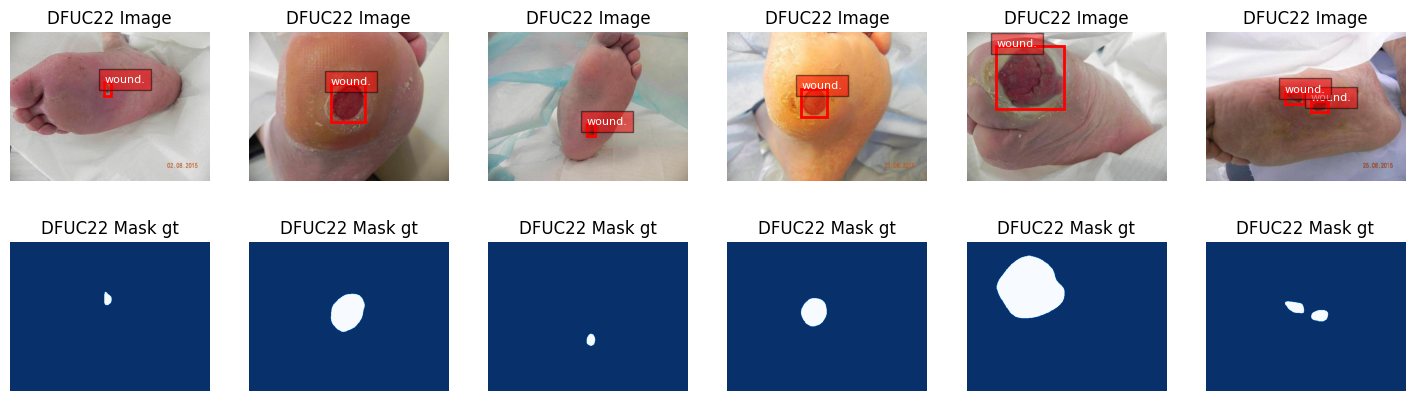

In [17]:
def show_subset(images, masks, targets, n):
    fig, ax = plt.subplots(2, n, figsize=(n*3, 5))
    for i in range(n):
        img = images[i].numpy()
        img = np.rollaxis(img, 0, 3) # np.rollaxis to swap channel axes to channels last
        mask = masks[i].numpy()
        bboxes = targets[i]['boxes'].numpy()
        labels = targets[i]['class_labels'].numpy()

        ax[0, i].imshow(img, vmin=0, vmax=1, cmap='gray') 
        ax[1, i].imshow(mask, vmin=0, vmax=1, cmap='Blues_r')   
        
        for bbox, label in zip(bboxes, labels):          
            x_min, y_min, w, h = bbox[0] - bbox[2] / 2, bbox[1] - bbox[3] / 2, bbox[2], bbox[3] # convert cx, cy, w, h, to x, y, w, h
            x_min, y_min, w, h = x_min * img.shape[1], y_min * img.shape[0], w * img.shape[1], h * img.shape[0] # denormalize bbox format
            rect = plt.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax[0, i].add_patch(rect)
            ax[0, i].text(x_min, y_min, id2label[label], color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
        
        ax[0, i].set_title('DFUC22 Image')
        ax[1, i].set_title('DFUC22 Mask gt')
        ax[1, i].axis('off')
        ax[0, i].axis('off')

    plt.show()

images, masks, targets = next(dataiter) # get a random batch of  iterator
show_subset(images, masks, targets, n=6) # show images, masks subset of size n of batch

## Defining the models

In [18]:
device = ("cuda" if torch.cuda.is_available() else "cpu") 
print(f"device: {device}")

device: cuda


### GroundedDINO Model

In [ ]:
from transformers import GroundingDinoProcessor, GroundingDinoForObjectDetection

# load grounding dino model for object detection
gd_model_id = "IDEA-Research/grounding-dino-base"
gd_model = GroundingDinoForObjectDetection.from_pretrained(gd_model_id, return_dict=True).to(device)
gd_processor = GroundingDinoProcessor.from_pretrained(gd_model_id)

# load checkpoint if available
GD_CHECKPOINTS = None # vanilla model
#GD_CHECKPOINTS = "./models/groundingdino_finetune/model_epoch53.pth" # finetuned model

if GD_CHECKPOINTS:
    gd_model.load_state_dict(torch.load(f'{GD_CHECKPOINTS}', map_location='cpu'))
    torch.cuda.empty_cache()
    print(f"use model checkpoints: {GD_CHECKPOINTS}")

print(gd_model)

### SAM Model

In [ ]:
from transformers import SamProcessor, SamModel

# load sam model
sam_model_id = "facebook/sam-vit-huge"
sam_model = SamModel.from_pretrained(sam_model_id, return_dict=True).to(device)
sam_processor = SamProcessor.from_pretrained(sam_model_id)

# load checkpoint if available
SAM_CHECKPOINTS = None # vanilla model
#SAM_CHECKPOINTS = "./models/sam_finetune/model_epoch29.pth" # finetuned model

if SAM_CHECKPOINTS:
    sam_model.load_state_dict(torch.load(f'{SAM_CHECKPOINTS}', map_location='cpu'))
    torch.cuda.empty_cache()
    print(f"use model checkpoints: {SAM_CHECKPOINTS}")

print(sam_model)

## Validation of the models

In [ ]:
SAVE_DIR = "./models/GroundingDino + SAM/GD_SAM (vanilla)"
#SAVE_DIR = "./models/GroundingDino + SAM/GD_SAMfinetune (GD vanilla, SAM fine-tuned)"
#SAVE_DIR = "./models/GroundingDino + SAM/GDfinetune_SAM (GD fine-tuned, SAM vanilla)"
#SAVE_DIR = "./models/GroundingDino + SAM/GDfinetune_SAMfinetune (GD fine-tuned, SAM fine-tuned)"

os.makedirs(SAVE_DIR, exist_ok=True)




# metrics for evaluation grondeddino model for object detection
gd_metrics = MetricCollection({
    "iou": IntersectionOverUnion(box_format='xyxy'),
    'map': MeanAveragePrecision(box_format='xyxy', iou_type='bbox')
})

# metrics for evaluation sam model for semantic segmentation
sam_metrics = MetricCollection({
    "dice": BinaryF1Score(threshold=0.5),
    'iou': BinaryJaccardIndex(threshold=0.5),
    'recall': BinaryRecall(threshold=0.5),
    'precision': BinaryPrecision(threshold=0.5),
    'cm': BinaryConfusionMatrix(normalize=None, threshold=0.5)
})


with torch.no_grad():
    # set models to evaluation mode
    gd_model.eval()
    sam_model.eval()

    # iterate over the validation dataset, get predictions of groundeddino for object detection and use it as prompts for sam model for semantic segmentation
    for (images, masks, targets) in tqdm(valid_loader):
        prompts = TEXT_PROMPT * images.shape[0] # repeat the text prompt for each image in the batch

        # forward GroundedDINO to get object detection predictions
        gd_inputs = gd_processor(images=images, text=prompts, return_tensors="pt").to(device)
        with autocast(device_type='cuda', dtype=torch.float16):
            gd_outputs = gd_model(**gd_inputs, labels=move_to_device(targets, device), return_dict=True)
        gd_preds = gd_processor.image_processor.post_process_object_detection(gd_outputs, threshold=0.3) 

        # compute GroundedDINO object detection metrics for the batch
        conv_targets = cxcywh2xyxy(targets)
        conv_targets = class_label2label(conv_targets)
        gd_metrics.update(move_to_device(gd_preds, "cpu"), conv_targets)

        
        # forward SAM model to get semantic segmentation predictions
        sam_prompts = convert_bbox_format2sam_prompts(gd_preds, image_width=images.shape[3], image_height=images.shape[2]) # convert groundeddino predictions to sam prompts
        sam_inputs = sam_processor(images=images, input_boxes=sam_prompts, return_tensors="pt").to(device)
        
        with autocast(device_type='cuda', dtype=torch.float16):
            sam_outputs = sam_model(**sam_inputs, return_dict=True, multimask_output=False)

        sam_preds = sam_processor.post_process_masks(masks=sam_outputs.pred_masks,original_sizes=sam_inputs.original_sizes,reshaped_input_sizes=sam_inputs.reshaped_input_sizes,binarize=False)
        sam_preds = torch.stack([torch.max(mask, dim=0).values.squeeze() for mask in sam_preds], dim=0)   # combine multiple masks to single mask

        # compute SAM segmentation metrics for the batch
        sam_preds = (sam_preds.sigmoid() > 0.5).int()
        sam_metrics.update(sam_preds.cpu(), masks)


# calculate overall metric results
eval_gd_metrics = gd_metrics.compute()
eval_sam_metrics = sam_metrics.compute()
eval_sam_metrics["fpv"] = eval_sam_metrics['cm'][0,1] / (eval_sam_metrics['cm'][0,1] + eval_sam_metrics['cm'][0,0])
eval_sam_metrics["fnv"] = eval_sam_metrics['cm'][1,0] / (eval_sam_metrics['cm'][1,0] + eval_sam_metrics['cm'][1,1])
eval_sam_metrics["ncm"] = eval_sam_metrics["cm"] / torch.sum(eval_sam_metrics["cm"], dim=1, keepdim=True)

print(f"Testdata evaluation results:\n", 
      f"GroundedDINO_IoU: {eval_gd_metrics['iou'].item():.5f}\n",
      f"GroundedDINO_mAP: {eval_gd_metrics['map'].item():.5f}\n",
      f"GroundedDINO_mAP50: {eval_gd_metrics['map_50'].item():.5f}\n",
      f"GroundedDINO_mAP75: {eval_gd_metrics['map_75'].item():.5f}\n",
      f"\n",
      f"SAM_IoU: {eval_sam_metrics['iou'].item():.5f}\n",
      f"SAM_Dice: {eval_sam_metrics['dice'].item():.5f}\n",
      f"SAM_Recall: {eval_sam_metrics['recall'].item():.5f}\n",
      f"SAM_Precision: {eval_sam_metrics['precision'].item():.5f}\n",
      f"SAM_FPE: {eval_sam_metrics['fpv'].item():.5f}\n",
      f"SAM_FNE: {eval_sam_metrics['fnv'].item():.5f}\n"
)

# Save the metrics as a JSON file
import json
# Function to convert tensors to standard Python data types
def convert_tensors(metrics_dict):
    converted_metrics = {}
    for key, value in metrics_dict.items():
        if isinstance(value, (np.ndarray, list, torch.Tensor)):
            converted_metrics[key] = value.tolist()
        elif hasattr(value, 'item'):  # for single-value tensors
            converted_metrics[key] = value.item()
        else:
            converted_metrics[key] = value
    return converted_metrics

    
with open(f'{SAVE_DIR}/eval_gd_metrics.json', 'w') as f:
    json.dump(convert_tensors(eval_gd_metrics), f)

with open(f'{SAVE_DIR}/eval_sam_metrics.json', 'w') as f:
    json.dump(convert_tensors(eval_sam_metrics), f)

### Confusion Matrix for segmentation results

In [ ]:
# confusion matrix computed earlier
cm = eval_sam_metrics['cm'].numpy()
ncm = eval_sam_metrics['ncm'].numpy()
print(f"confusion matrix:\n{cm}\n"
     f"normalized confusion matrix:\n{ncm}")

# plot confusion matrix
fig, ax = plt.subplots(1,1)
cm_fig = ax.imshow(ncm, interpolation='nearest', cmap="Blues") # plot confusion matrix background color 
fig.colorbar(cm_fig, ax=ax) # add confusion matrix color bar
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['background', 'wound'])
ax.set_yticklabels(['background', 'wound'])
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth') 
ax.set_title("Confusion Matrix")

# plot confusion matrix values
for ix, iy in np.ndindex(ncm.shape):
    ax.text(iy, ix, f"{100*ncm[ix, iy]:.2f}%", horizontalalignment="center", color="white" if ncm[ix, iy] > ncm.max() / 2.0 else "black")


fig.savefig(f'{SAVE_DIR}/confusion_matrix.png', dpi=100, format="png")
plt.show()    

### Show example predictions

In [34]:
def show_preds(images, masks, targets, results, pred_masks, n):
    fig, ax = plt.subplots(3, n, figsize=(n*4, 8))
    for i in range(n):
        img = images[i].numpy()
        img = np.rollaxis(img, 0, 3) 
        bboxes = targets[i]['boxes'].detach().numpy()
        labels = targets[i]['class_labels'].detach().numpy()
        pred_bboxes = results[i]['boxes'].detach().numpy()
        pred_labels = results[i]['scores'].detach().numpy()

        ax[0, i].imshow(img, vmin=0, vmax=1)
        ax[2, i].imshow(masks[i].numpy(), vmin=0, vmax=1, cmap='Blues_r')   
        ax[1, i].imshow(pred_masks[i], vmin=0, vmax=1, cmap='Blues_r')   

        for bbox, label in zip(bboxes, labels):
            x_min, y_min, w, h = bbox[0] - bbox[2] / 2, bbox[1] - bbox[3] / 2, bbox[2], bbox[3]
            x_min, y_min, w, h = x_min * img.shape[1], y_min * img.shape[0], w * img.shape[1], h * img.shape[0]
            rect = plt.Rectangle((x_min, y_min), w, h,
                                 linewidth=2, edgecolor='red', facecolor='none')
            ax[0, i].add_patch(rect)
            ax[0, i].text(x_min, y_min, id2label[label], color='white', fontsize=8,
                       bbox=dict(facecolor='red', alpha=0.5))

        for pred_bbox, pred_label in zip(pred_bboxes, pred_labels):
            x_min, y_min, x_max, y_max = pred_bbox[0] * img.shape[1], pred_bbox[1] * img.shape[0], pred_bbox[2] * img.shape[1], pred_bbox[3] * img.shape[0]
            rect2 = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='blue', facecolor='none')
            ax[0, i].add_patch(rect2)
            ax[0, i].text(x_min, y_min, f"{(pred_label*100):.1f}", color='white', fontsize=8,
                       bbox=dict(facecolor='blue', alpha=0.5))

        ax[0, i].set_title('GroundedDINO OD pred. (blue)')
        ax[2, i].set_title('DFUC22 GT-Mask')
        ax[1, i].set_title('SAM pred.')
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')

    plt.show()      


dataiter = iter(valid_loader) # get iterator of valid data loader 

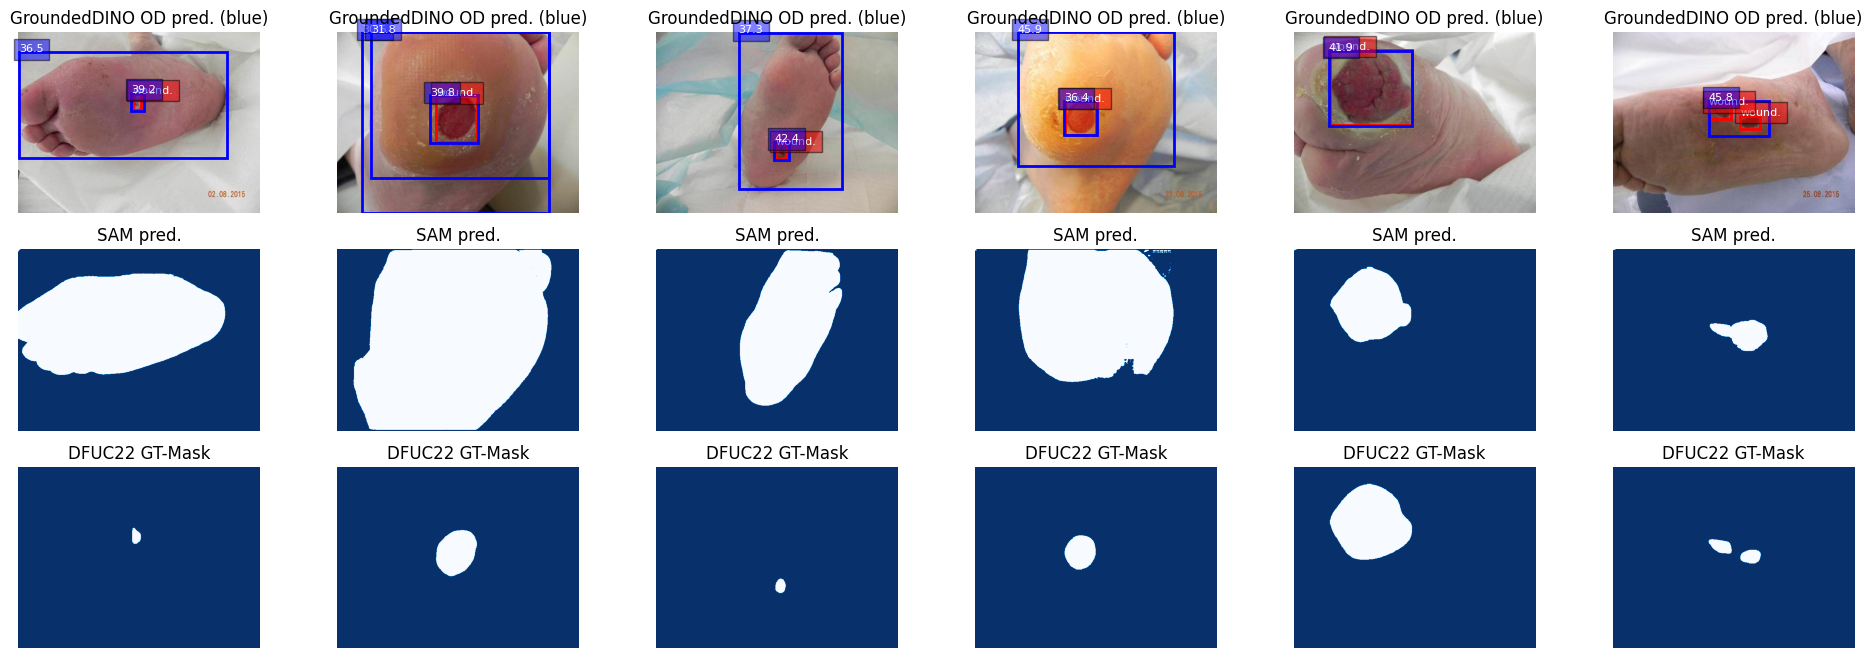

In [35]:
images, masks, targets = next(dataiter) # get a random batch of train_loader iterator
prompts = TEXT_PROMPT * images.shape[0]

with torch.no_grad():
    gd_model.eval()
    sam_model.eval()

    # forward GroundedDINO to get object detection predictions
    gd_inputs = gd_processor(images=images, text=prompts, return_tensors="pt").to(device)
    
    with autocast(device_type='cuda', dtype=torch.float16):
        gd_outputs = gd_model(**gd_inputs, labels=move_to_device(targets, device), return_dict=True)
    
    gd_results = gd_processor.image_processor.post_process_object_detection(gd_outputs, threshold=0.3)

    # forward SAM to get segmentations
    sam_prompts = convert_bbox_format2sam_prompts(gd_results, image_width=images.shape[3], image_height=images.shape[2])
    sam_inputs = sam_processor(images=images, input_boxes=sam_prompts, return_tensors="pt").to(device)
    with autocast(device_type='cuda', dtype=torch.float16):
        sam_outputs = sam_model(**sam_inputs, return_dict=True, multimask_output=False)

    sam_preds = sam_processor.post_process_masks(masks=sam_outputs.pred_masks,original_sizes=sam_inputs.original_sizes,reshaped_input_sizes=sam_inputs.reshaped_input_sizes,binarize=False)
    sam_preds = torch.stack([torch.max(mask, dim=0).values.squeeze() for mask in sam_preds], dim=0) # combine multiple masks to single mask
    sam_preds = (sam_preds.sigmoid() > 0.5).int() # binarize the mask
 
show_preds(images, masks, targets, move_to_device(gd_results, "cpu"), sam_preds.cpu().numpy(), n=6) # show images, masks subset of size n of batch